In [19]:
'''
    Import packages and modules from Python Standard Library and Third party libraries.
'''
#Import from python standard library
import os

#Import from third party libraries 
import cv2
import glob
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
%matplotlib inline

In [20]:
#Read files and get a dictionary with image 'name.png' as key and 'bounding box coordinates' as value
#Each file contains name.png and bounding box coordinates in each row
allBoxes = {}
files = ['FallingDown_01.txt','FallingDown_02.txt','Standing_01.txt','Standing_02.txt']
path = './output/'

for filename in files:
    boxes = {}
    with open(path+filename,'r') as file:
        for line in file:
            tokens = line.split(' ',1)
            name,box = tokens[0].strip(), tokens[1].strip()
            boxes[name] = box
    key = filename.split('.')[0]
    allBoxes[key]=boxes    

In [21]:
#define list to store the dataset 
dataset = []
#define list to store the data labels 
dataLabels = []
#list of main-directory names
DIRs = ['FallingDown_01','FallingDown_02','Standing_01','Standing_02']
#iterate over each main-directory name
for DIR in DIRs:
    #join path with each main-directory name
    path = 'C:/Users/rashi/Desktop/original/yolact/output/'+str(DIR)
    print('DIR',DIR)
    #Extract the path of all sub-directories inside each main-directory 
    for directory in glob.glob(path):
        sub_path = os.path.join(directory+'/*.png')
        #extract path of all images in sub-directory
        image_paths = glob.glob(sub_path)
        #split the directory path and extract directory name
        labels = directory.split('\\')[-1]
        #Iterate over each image path to read the image 
        for image_path in image_paths:
            name = os.path.basename(image_path)
            try:
                box = allBoxes[DIR][name]
                box_tokens = [ tk for tk in box.strip('[,]').split(' ') if tk is not '']
                x1 = box_tokens[0].strip(' ')
                y1 = box_tokens[1].strip(' ')
                x2 = box_tokens[2].strip(' ')
                y2 = box_tokens[3].strip(' ')
                box = x1,y1,x2,y2
                x1,y1,x2,y2 = int(x1),int(y1),int(x2),int(y2)
                img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
                image = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
                #print(image.shape)
                image = image[y1:y2,x1:x2]
                image = cv2.resize(image,dsize=(300,300), interpolation= cv2.INTER_AREA)
                output_path = path+'/cropped/'+name+'.png'
                cv2.imwrite(output_path,cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
                #print(image.shape)
                #convert to rgb if grayscale image 
                if len(image.shape)==2:
                    image = gray2rbg(image)
                if DIR is 'FallingDown_01' or DIR is 'FallingDown_02':
                    #append image to dataset list  
                    dataset.append(image)
                    dataLabels.append(int(1))
                elif DIR=='Standing_01' or DIR=='Standing_02':
                    dataset.append(image)
                    dataLabels.append(int(0))
            except KeyError:
                print('Key Error')
                
#convert dataset and data_labels to numpy array        
dataset = np.array(dataset)
dataLabels = np.array(dataLabels)

print('Dataset Shape: {0} Labels Shape: {1}'.format(dataset.shape, dataLabels.shape))

DIR FallingDown_01
Key Error
Key Error
Key Error
Key Error
Key Error
Key Error
Key Error
Key Error
Key Error
Key Error
Key Error
Key Error
Key Error
Key Error
Key Error
Key Error
Key Error
Key Error
Key Error
Key Error
Key Error
Key Error
Key Error
DIR FallingDown_02
Key Error
Key Error
Key Error
DIR Standing_01
DIR Standing_02
Key Error
Key Error
Key Error
Key Error
Key Error
Dataset Shape: (1625, 300, 300, 3) Labels Shape: (1625,)


In [22]:
dataset.shape

(1625, 300, 300, 3)

In [23]:
class_names=['Stand','Fall']

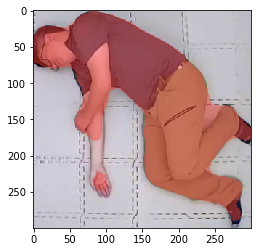

In [24]:
plt.imshow(dataset[0])

In [25]:
class_names[dataLabels[0]]

'Fall'

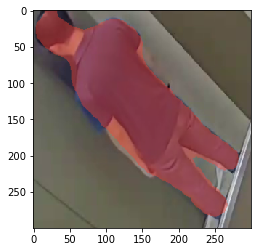

In [26]:
plt.imshow(dataset[1600])

In [27]:
class_names[dataLabels[1600]]

'Stand'

In [28]:
#shuffle dataset and split dataset into train, test and validation sets
dataset, dataLabels = shuffle(dataset, dataLabels, random_state=1236)
train_x, train_y = dataset[:1000], dataLabels[:1000]
test_x, test_y   = dataset[1000:1400], dataLabels[1000:1400]
valid_x, valid_y = dataset[1400:], dataLabels[1400:]
train_x.shape,train_y.shape, test_x.shape, test_y.shape, valid_x.shape, valid_y.shape 

((1000, 300, 300, 3),
 (1000,),
 (400, 300, 300, 3),
 (400,),
 (225, 300, 300, 3),
 (225,))

In [29]:
#methods to rescale images
def pre_process_image(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    return image, label

In [30]:
#convert train, test and validation sets to tensorflow datasets 
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
test_dataset  = tf.data.Dataset.from_tensor_slices((test_x, test_y))
valid_dataset  = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))

In [32]:
#map train and valid dataset to preprocessing function, shuffle, 
TRAIN_BATCH_SIZE = 4
train_dataset = train_dataset.map(pre_process_image).shuffle(1000).repeat().batch(TRAIN_BATCH_SIZE)
valid_dataset = valid_dataset.map(pre_process_image).repeat().batch(4)

In [33]:
#load ResNet pretrained model from tf.keras library
IMG_SHAPE = dataset.shape[1:]
res_net = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

In [34]:
res_net.trainable = True

In [41]:
global_average_layer = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(1, activation='sigmoid')
tl_model = tf.keras.Sequential([
  res_net,
  global_average_layer,
  output_layer])

In [42]:
tl_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 10, 10, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


In [44]:
tl_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])
path = os.path.join('log','transfer_learning_model')
callbacks = [tf.keras.callbacks.TensorBoard(log_dir=path , update_freq='batch', profile_batch = 100000000)]

history = tl_model.fit(train_dataset, steps_per_epoch = 500, epochs=10, 
             validation_data=valid_dataset, validation_steps=50, callbacks=callbacks)

Train for 2000 steps, validate for 200 steps
Epoch 1/10
2000/2000 [==============================] - 192s 96ms/step - loss: 0.1538 - accuracy: 0.9484 - val_loss: 0.3520 - val_accuracy: 0.8612
Epoch 2/10
2000/2000 [==============================] - 187s 93ms/step - loss: 0.0355 - accuracy: 0.9896 - val_loss: 0.0072 - val_accuracy: 0.9962
Epoch 3/10
2000/2000 [==============================] - 188s 94ms/step - loss: 0.0558 - accuracy: 0.9820 - val_loss: 0.0949 - val_accuracy: 0.9550
Epoch 4/10
2000/2000 [==============================] - 189s 94ms/step - loss: 0.0143 - accuracy: 0.9954 - val_loss: 0.0094 - val_accuracy: 0.9962
Epoch 5/10
2000/2000 [==============================] - 312s 156ms/step - loss: 0.0167 - accuracy: 0.9940 - val_loss: 0.0248 - val_accuracy: 0.9962
Epoch 6/10
2000/2000 [==============================] - 184s 92ms/step - loss: 3.2878e-04 - accuracy: 1.0000 - val_loss: 0.0146 - val_accuracy: 0.9962
Epoch 7/10
2000/2000 [==============================] - 185s 92ms/st

In [45]:
# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
tl_model.save("./fall_model/model_2.h5")

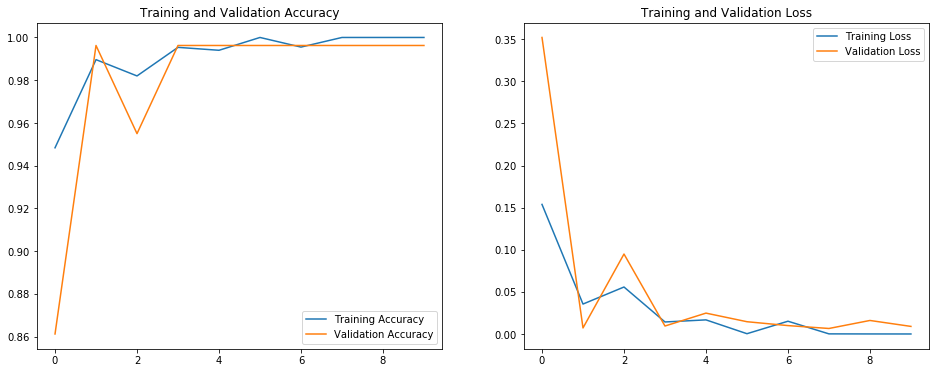

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('resnet50.jpg')
plt.show()

In [ ]:
# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("./fall_model/model_1.h5")

In [53]:
test_dataset = test_dataset.map(pre_process_image).shuffle(buffer_size=1024).batch(9)

In [54]:
test_dataset

<BatchDataset shapes: ((None, 300, 300, 3), (None,)), types: (tf.float32, tf.int32)>

In [55]:
result = tl_model.evaluate(test_dataset)

45/45 [==============================] - 3s 69ms/step - loss: 0.0196 - accuracy: 0.9950


Confidence: tf.Tensor(
[[0.73105806]
 [0.7310586 ]
 [0.7310586 ]
 [0.7310586 ]
 [0.5000003 ]
 [0.7310586 ]
 [0.5       ]
 [0.5       ]
 [0.7310586 ]], shape=(9, 1), dtype=float32)
Predictions:
 [1 1 1 1 0 1 0 0 1]
Labels:
 [1 1 1 1 0 1 0 0 1]


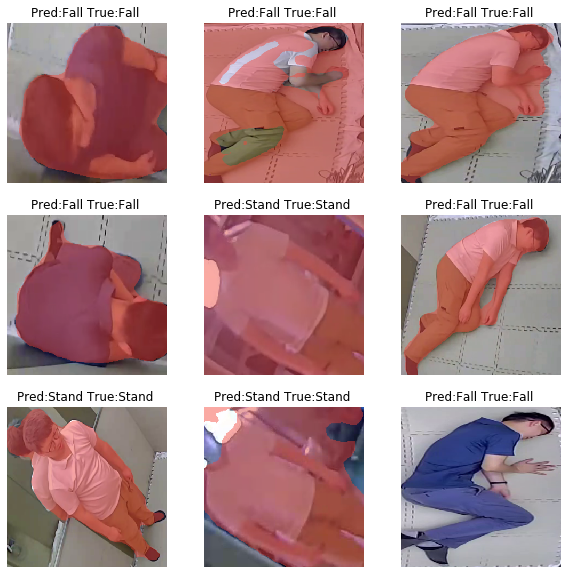

In [106]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = tl_model.predict_on_batch(image_batch)

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
print('Confidence:',predictions)
predictions = tf.where(predictions < 0.6, 0, 1)
predictions = predictions.numpy().ravel()

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i])
    plt.title('Pred:{} True:{} '.format(class_names[predictions[i]], class_names[label_batch[i]]))
    plt.axis("off")

In [4]:
#test on single image
image = test_x[3]/255
image =  tf.expand_dims(image, axis=0)
tl_model.predict(image)

NameError: name 'test_x' is not defined